# Vital_Sign_Pred
## Paper: Hybrid Neural Network Models to Estimate Vital Signs from Facial Videos
## Date: 2025-01-08
**Author:** [Yufeng Zheng]<br>
**Last modified:**2025-01-08<br>
**Description:** <br>
(i) Predict Vital (x7) from Face Video (1Sx30F x 288x256x3) using Hybrid model: CNN, convLSTM, Vision Transformer <br>
Vital (x7): HR, BPH, BPL, SPO2, SknClr, Sex, Age <br/>
(ii) Hybird(x) --3Sx30F--> LSTM(512) model <br/>
(iii) concat [3D_Conv, ViT, convLSTM]  <br/>

## Setup

In [1]:
%load_ext autotime
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import sys

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

gpus = tf.config.experimental.list_physical_devices('GPU')    #work around GPU memory overflow
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)       # Don't pre-allocate memory; allocate as-needed -- Must be disabled for Multi-GPUs

name_vital = ['HR', 'BPH', 'BPL', 'SPO2', 'Sex', 'Age'] #<<<<<<<<<<<<<<<<<<<<<<<<<< Original Order in [Y]
mdl_name = 'Mdl_a'    # Mdl_a, Mdl_b, Mdl_c, HMdl_ab, HMdl_ac, HMdl_bc, HMdl_abc
# mdl_name = 'HMdl_ac'    # Mdl_a, Mdl_b, Mdl_c, HMdl_ab, HMdl_ac, HMdl_bc, HMdl_abc
path_weights = '../rslt/'

fn_weights_wr = path_weights + mdl_name + '.weights.h5'
fn_weights_rd = fn_weights_wr


2025-01-11 21:14:54.787358: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-11 21:14:54.799640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736651694.814686 2132106 cuda_dnn.cc:8498] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736651694.819186 2132106 cuda_blas.cc:1410] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-11 21:14:54.834221: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

2.19.0-dev20241101
Num GPUs Available:  2
time: 2.21 s (started: 2025-01-11 21:14:54 -06:00)


# Prepare the data
**2021-08-21: DLUT with Normalization**

In [2]:
import scipy.io
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


time: 232 ms (started: 2025-01-11 21:14:56 -06:00)


## Build the Enc-CNN-convLSTM model


In [3]:
# classes for defining transformer

NUM_OUTPUTS = 7
LAYER_NORM_EPS = 1e-6
NUM_HEADS = 8  
NUM_LAYERS = 8 
DIM_HEAD = 64
EMBED_DIM = 256  

class PatchEmbedding(layers.Layer):             # modified on 2023-10-25  # 2D Embedding --> original pixel values
    def __init__(self,patch_size, **kwargs):    # patch_size=(6,4)
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, videos):    # flag_3D := True: multi-frame video; # := Flase: 1-frame image
        num_frm = tf.shape(videos)[0]
        #print('PatchEmbedding_0: ', videos.shape)##### (None, 7, 16, 16, 64) (None, 1792, 64)
        ## x = tf.squeeze(videos, axis=0)    # must specify: axis=1 -- squeeze batch [None] out, but keep 1-frame dim
        frm_patches = tf.image.extract_patches(videos, sizes=[1,  self.patch_size[0],  self.patch_size[1], 1],
                            strides=[1,  self.patch_size[0],  self.patch_size[1], 1], rates=[1, 1, 1, 1], 
                            padding='VALID')    # (None, 9, 8, patch_size[0]*patch_size[1]*64) : [1,8,8,4608]
        patch_dim = frm_patches.shape[-1]
        patch_num_1 = frm_patches.shape[1]
        patch_num_2 = frm_patches.shape[2]
        flat_patches = tf.reshape(frm_patches, [num_frm, patch_num_1*patch_num_2, patch_dim])    # 1152=9*8*16 
        print('PatchEmbedding: ', frm_patches.shape, flat_patches.shape)##### (None, 8, 8, 1152) (None, 64, 1152)
        return flat_patches


class TubeletEmbedding(layers.Layer):           # modified on 2023-10-02  # 3D Embedding
    def __init__(self,patch_size, **kwargs):    # patch_size_3d=((1,6,4,384),(1,4,4,768))  # __init__(self, embed_dim, patch_size, **kwargs)
        super().__init__(**kwargs)
        if len(patch_size) == 2:
            tube_proj = Sequential( [
                layers.Conv3D( filters=patch_size[0][3], kernel_size=patch_size[0][:3], strides=patch_size[0][:3], padding="VALID" ),
                layers.LayerNormalization(epsilon=1e-6),
                layers.Conv3D( filters=patch_size[1][3], kernel_size=patch_size[1][:3], strides=patch_size[1][:3], padding="VALID" ),
                layers.LayerNormalization(epsilon=1e-6),
                ], name ='Tubelet_Embedding', )
        elif len(patch_size) == 3:           #2024-06-25
            tube_proj = Sequential( [
                layers.Conv3D( filters=patch_size[0][3], kernel_size=patch_size[0][:3], strides=patch_size[0][:3], padding="VALID" ),
                layers.LayerNormalization(epsilon=1e-6),
                layers.Conv3D( filters=patch_size[1][3], kernel_size=patch_size[1][:3], strides=patch_size[1][:3], padding="VALID" ),
                layers.LayerNormalization(epsilon=1e-6),
                layers.Conv3D( filters=patch_size[2][3], kernel_size=patch_size[2][:3], strides=patch_size[2][:3], padding="VALID" ),
                layers.LayerNormalization(epsilon=1e-6),
                ], name ='Tubelet_Embedding', )
        # self.projection = layers.Conv3D(       # input_x: n,24,224,224,3; patch_size=(3,16,16) --> output: n x 8 x 14 x 14 x filters
        #     filters=embed_dim,
        #     kernel_size=patch_size,
        #     strides=patch_size,
        #     padding="VALID",
        # )
        self.projection = tube_proj
        self.flatten = layers.Reshape(target_shape=(-1, patch_size[-1][3]))    # embed_dim == patch_size[-1][:3]  #output: 8*14*14 x filters

    def call(self, videos):    # flag_3D := True: multi-frame video; # := Flase: 1-frame image
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        print('TubeletEmbedding: ', projected_patches.shape, flattened_patches.shape)##### (None, 7, 16, 16, 64) (None, 1792, 64)
        return flattened_patches, tf.shape(projected_patches)            #projected_patches.shape: [None, 30, 4, 3, 384]


class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):     # 128
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape                                             # input_shape = (None, 1792, 64)
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        
        # if  encoded_tokens.shape[0] == 1 and encoded_positions.shape[0] != 1:
        #     encoded_positions = encoded_positions[None,]
            # encoded_tokens = tf.squeeze(encoded_tokens, axis=0)
        
        print('PositionalEncoder: ', encoded_tokens.shape, encoded_positions.shape)##### (None, 1792, 64) (1792, 64)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    head_dim=DIM_HEAD,
    embed_dim=EMBED_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_outputs=NUM_OUTPUTS,
    name_model='ViViT',
    flag_encoder=True,     # False -> No encoder, return encoded_patches
    flag_decoder=False,    # True    # False -> No Decoder    # <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    flag_pooling=False,    # False -> omit pooling layer
    flag_flatten=False,    # False -> omit flatten layer
    pool_size=4,           # when flag_pooling=True 
    flag_pooling_avg=True, # True -> AveragePooling; False -> MaxPooling
):
    if tubelet_embedder is None:    # No need to create patches using tubelet_embedder 
        inputs = layers.Input(shape=input_shape)    # Get the input layer
        patches = inputs
    else:
        inputs = layers.Input(shape=input_shape)    # Get the input layer    
        patches, numPatches = tubelet_embedder(inputs)          # Create patches

    if flag_encoder == False:                       # No encoder & No decoder -- just split into patches and project to embedding vectors
        model = keras.Model(inputs=inputs, outputs=patches, name=name_model)
        return model
    
    encoded_patches = positional_encoder(patches)   # Encode patches = #Tokens(Words) x embed_dim(64) -- encode position only when encoder True
    
    x1 = encoded_patches                            
    # Create multiple layers of the Transformer block -- Encoder
    for k in range(transformer_layers):
        print('ViViT Encoding Layer_', k)
        # Layer normalization and MHSA
        # x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=head_dim, value_dim=head_dim, dropout=0.02        #  key_dim=embed_dim // num_heads,
        )(x1, x1, x1, attention_mask=None)                                   # query, value, key
        # dropout()

        # Skip connection
        x1 = layers.Add()([attention_output, x1])
        # Layer Normalization and MLP
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)
        
        feedforward_output = keras.Sequential(                               # feed_forward
            [
                layers.Dense(units=embed_dim*4, activation=tf.nn.gelu),      # d_FF_L1 = embed_dim*4
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),        # d_FF_L2 === embed_dim
            ]
        )(x1)
        # dropout()

        # Skip connection
        x1 = layers.Add()([feedforward_output, x1])
        x1 = layers.LayerNormalization(epsilon=1e-6)(x1)        # n x 448 x 256(d_FF_L2)

    
    if flag_decoder == True:
        # Create multiple layers of the Transformer block -- Decoder
        encoder_output = x1
        x2 = encoded_patches
        for k in range(transformer_layers):
            print('ViViT Decoding Layer_', k)
            attention_output = layers.MultiHeadAttention(
                num_heads=num_heads, key_dim=head_dim, value_dim=head_dim, dropout=0.02
            )(x2, x2, x2, attention_mask=None)                                   # attention_mask = 
            # Skip connection
            x2 = layers.Add()([attention_output, x2])
            # Layer Normalization and MLP
            x2 = layers.LayerNormalization(epsilon=1e-6)(x2)

            attention_output = layers.MultiHeadAttention(                        # attention_output 2 
                num_heads=num_heads,key_dim=head_dim, value_dim=head_dim, dropout=0.02
            )(query=x2, value=encoder_output, key=encoder_output, use_causal_mask=None)          # attention_mask = lookahead_mask
            # attention_output = layers.MultiHeadAttention(                        # attention_output 2 
            #     num_heads=num_heads,key_dim=embed_dim, value_dim=embed_dim, dropout=0.1
            # )(query=encoder_output, value=encoder_output, key=encoder_output, use_causal_mask=None)          # attention_mask = lookahead_mask
            # Skip connection
            x2 = layers.Add()([attention_output, x2])
            # Layer Normalization and MLP
            x2 = layers.LayerNormalization(epsilon=1e-6)(x2)

            feedforward_output = keras.Sequential(                               # feed_forward
                [
                    layers.Dense(units=embed_dim*4, activation=tf.nn.gelu),
                    layers.Dense(units=embed_dim, activation=tf.nn.gelu),
                ]
            )(x2)
            # dropout()
            # Skip connection
            x2 = layers.Add()([feedforward_output, x2])
            x2 = layers.LayerNormalization(epsilon=1e-6)(x2)

        x1 = x2    ########################################### flag_decoder == True
    
    
    # Layer normalization and Global average pooling.
    x = layers.LayerNormalization(epsilon=layer_norm_eps)(x1)    # n x 343 x 512, n x 448*4 x 64
    if flag_pooling == True:
        xShape = tf.shape(x)    # [None, 360, 384]
        totalNumPatches = numPatches[2]*numPatches[3]    #numPatches: [None, 30, 4, 3, 384]
        x = tf.reshape(x, [xShape[0], xShape[1]//totalNumPatches, numPatches[2], numPatches[3], xShape[2]])
        # x = layers.Reshape(target_shape=(xShape[1]//totalNumPatches, numPatches[2], numPatches[3], embed_dim))(x)    # embed_dim == xShape[4]
        print("--Before Pooling: ", x.shape)
        
        if flag_pooling_avg == True:
            print('==Transformer with AveragePooling2D(); pool_size =', pool_size)
            # x = layers.TimeDistributed(layers.AveragePooling1D(pool_size=pool_size, strides=pool_size, padding="same"))(x)
            x = layers.TimeDistributed(layers.AveragePooling2D(pool_size=pool_size, strides=pool_size, padding="valid"))(x)
        else:
            print('__Transformer with MaxPooling2D(); pool_size =', pool_size)
            x = layers.TimeDistributed(layers.MaxPooling2D(pool_size=pool_size, strides=pool_size, padding="valid"))(x)    # nx512
        
        #print("--After Pooling:", x.shape.as_list())
        
        xShape = tf.shape(x)    # [None, 30, 1, 4, 384]
        # x = layers.Reshape(target_shape=(-1, embed_dim))(x)    # embed_dim == xShape[4]
        x = tf.reshape(x,[xShape[0], xShape[1], xShape[2]*xShape[3]*xShape[4]])
        #print("--After Reshape:", x.shape.as_list())    # [None, 30, 1536]
    
    if flag_flatten == True:
        x = layers.Flatten()(x)        # 1536 = 24 x 64
        #print("--After Flatten():", x.shape.as_list())

    model = keras.Model(inputs=inputs, outputs=x, name=name_model)
    return model


time: 5.73 ms (started: 2025-01-11 21:14:57 -06:00)


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

from keras import backend
# from keras.engine import sequential
# from keras.engine import training as training_lib
from keras import Sequential

# from def_my_model import create_vivit_classifier, TubeletEmbedding, PositionalEncoder, PatchEmbedding

def Stem(num_filters=64, kernel_size=4, strides=4, name=None):
    stem = Sequential(
        [
            layers.Conv2D(
                filters=num_filters,
                kernel_size=kernel_size,
                strides=strides,
                name=name + "_stem_conv",
            ),
            layers.LayerNormalization(
                epsilon=1e-6, name=name + "_stem_layernorm"
            ),
        ],
        name=name + "_stem",
    )

    return stem        
        
def Trunk(flag_glb_pooling=True, num_fc_units=0, dropout_rate=0.2, activation=tf.nn.gelu, name=None):
    if name is None:
        name = str(backend.get_uid("trunk"))

    def apply(x):
        if flag_glb_pooling == True:
            x = layers.TimeDistributed(layers.GlobalAveragePooling2D(name=name + "_trunk_pool"))(x)
        
        if num_fc_units > 0:
            x = layers.LayerNormalization(
                epsilon=1e-6, name=name + "_trunk_fc_layernorm"
            )(x)
            x = layers.Dropout(dropout_rate)(x)
            x = layers.Dense(
                units=num_fc_units,
                activation=activation,
                name=name + "_trunk_fc",
            )(x)
        
        return x

    return apply


def Head(num_fc_units=512, num_classes=7, dropout_rate=(0.2,0,1), activation=('gelu', 'sigmoid'), name=None):
    if name is None:
        name = str(backend.get_uid("head"))

    def apply(x):
        if num_fc_units > num_classes:
            # x = layers.LayerNormalization(
            #     epsilon=1e-6, name=name + "_head_fc_layernorm"
            # )(x)
            x = layers.Dropout(dropout_rate[0])(x)
            x = layers.Dense(
                units=num_fc_units,
                activation=activation[0],
                name=name + "_head_fc",
            )(x)
        
        x = layers.LayerNormalization(
            epsilon=1e-6, name=name + "_head_layernorm"
        )(x)
        x = layers.Dropout(dropout_rate[1])(x)
        x = layers.Dense(
            units=num_classes,
            activation=activation[1],
            name=name + "_head_dense",
        )(x)
        return x

    return apply

#2024-03-25: for Residual layer --  learned from Make_Xception_Model()
def Down_Smpl_V2(num_filters=512, strides=(2,2), name='Down_Smpl', blk_no=1):
    dwn_smpl_layer = Sequential(
        [
            layers.LayerNormalization(
                epsilon=1e-6,
                name=name + "_downsampling_layernorm_" + str(blk_no),
            ),
            layers.Conv2D(
                filters=num_filters,
                kernel_size=(1, 1),
                strides=strides,
                padding='same',
                use_bias=False,
                name=name + "_downsampling_conv_" + str(blk_no),
            ),
        ],
        name=name + "_downsampling_block_" + str(blk_no)
    )

    return dwn_smpl_layer

#2024-03-25: for Residual layer --  learned from Make_Xception_Model()
def Conv_2D_V2(num_filters=128, kernel_size=4, strides=(2,2), name='Conv_2D', blk_no=1):    # residual / identity
    conv_2d = Sequential(
        [    
            layers.SeparableConv2D(
                filters=num_filters,
                kernel_size=kernel_size,
                use_bias=False,
                padding="same",
                name=name + "_depthwise_conv",
            ),
            layers.BatchNormalization(epsilon=1e-6, name=name + "_batnorm"),
            layers.Activation("relu", name=name + "_actrelu"),
            layers.MaxPooling2D(pool_size=kernel_size, strides=strides,
                            padding='same', name=name + '_maxpooling'),
        ],
        name=name + "_Conv2D_"+str(blk_no)
    )

    return conv_2d

#2024-03-25: for Residual layer --  learned from Make_Xception_Model()
def Conv_2D_Res_V2(num_filters=128, kernel_size=4, strides=(4,4), name=None, blk_no=1):    # residual / identity
    if name is None:
        name = str(backend.get_uid("Conv2D"))
    else:
        name = name + '_blk_' + str(blk_no)
    
    def apply(x):               
        if strides[0] + strides[1] > 2:
            res_x = layers.TimeDistributed(Down_Smpl_V2(num_filters=num_filters, strides=strides, name=name, blk_no=blk_no))(x)

        x = layers.TimeDistributed(Conv_2D_V2(num_filters=num_filters, kernel_size=kernel_size, strides=strides, name=name, blk_no=blk_no))(x)
        
        if strides[0] + strides[1] > 2:
            return x + res_x
        else:
            return x
    
    return apply

def ViViT_Attn_V2(input_shape=(30,72,64,64), patch_size_3d=((1,8,8,256),(1,3,2,512)), vit_para=(6,8,64,512), name=None):
    assert (vit_para[3] == patch_size_3d[-1][3])    # $filters in Conv3D == #embed_dim
    if name is None:
        name = str(backend.get_uid("Attn"))

    def apply(x):
        attn_trnsfm = create_vivit_classifier(
            tubelet_embedder=TubeletEmbedding(patch_size=patch_size_3d),    #  patch_size_3d: frm, h, w 
            positional_encoder=PositionalEncoder(embed_dim=vit_para[3]),
            input_shape=input_shape,     # frm, h, w, c : 30,72,64,64
            transformer_layers=vit_para[0],        # 12,  24,   24,   24    96    # 6
            num_heads=vit_para[1],                 # 12,  16,   16,   24    96
            head_dim=vit_para[2],                  # 64,  64,   96,   128   128
            embed_dim=vit_para[3],                 # 768, 1024, 1536, 2048  12288
            name_model=name+'_ViViT_Attn',         # sm,        mid,        lg
            flag_pooling=False,          # MaxPooling1D(pool_size=4, strides=4)
            flag_flatten=True,           # False:
            )
        return attn_trnsfm(x)
    
    return apply


def Conv_LSTM(num_filters=128, kernel_size=(2,2), strides=(2,2), name=None, blk_no=1, flag_bidir=False):
    if name is None:
        name = str(backend.get_uid("ConvLSTM"))

    def apply(x):
        my_conv_lstm = layers.ConvLSTM2D(filters=num_filters, kernel_size=kernel_size, strides=strides
                , data_format='channels_last'
                , recurrent_activation='hard_sigmoid'
                , activation='tanh'
                , padding='same'
                , return_sequences=True
                , name=name+"_ConvLSTM_"+str(blk_no))      # 1x160x128x64 -- # merge_mode='sum', or 'concat' <--(2b)
        if flag_bidir == True:
            x = layers.Bidirectional(my_conv_lstm, merge_mode='concat', name='BiDir_'+str(blk_no))(x)
        else:
            x = my_conv_lstm(x)
        # x = layers.TimeDistributed(layers.MaxPool2D(pool_size=(2,2),strides=(2,2),padding='same'))(x)      
        x = layers.LayerNormalization(epsilon=1e-6,
                    name=name + "_ConvLSTM_layernorm_"+str(blk_no))(x)        # BatchNormalization(): (None, 320, 8, 8, num_filters)      
        return x
    
    return apply

def Make_Hybrid_Model(input_shape=(30,288,256,3), patch_size_3d=(3,8,8), embed_dim=512, num_outputs=7,  
                            model_name='Mdl_a'):
    vf_input = layers.Input(shape=input_shape, name=model_name+'_input')
   
    # Stem block.
    stem_out = layers.TimeDistributed(Stem(num_filters=64, kernel_size=4, strides=4, name=model_name))(vf_input)
    stem_out_shape = stem_out.shape                       # (30,72,64,64)
       
    feat_conv_3d = Conv_2D_Res_V2(num_filters=64, kernel_size=7, strides=(1,1), name=model_name, blk_no=1)(stem_out)
    feat_conv_3d = Conv_2D_Res_V2(num_filters=128, kernel_size=5, strides=(3,2), name=model_name, blk_no=2)(feat_conv_3d)
    feat_conv_3d = Conv_2D_Res_V2(num_filters=256, kernel_size=3, strides=(2,2), name=model_name, blk_no=3)(feat_conv_3d)    
    feat_conv_3d = Conv_2D_Res_V2(num_filters=512, kernel_size=3, strides=(2,2), name=model_name, blk_no=4)(feat_conv_3d)    
    #feat_conv_3d = Conv_2D_Res(num_filters=1024, kernel_size=3, strides=(2,2), name=model_name, blk_no=5)(feat_conv_3d)      
    feat_conv_3d = Conv_2D_Res_V2(num_filters=embed_dim, kernel_size=3, strides=(2,2), name=model_name, blk_no=5)(feat_conv_3d)      
    #feat_conv_3d = Trunk(flag_glb_pooling=True, num_fc_units=0, dropout_rate=0.2, activation=tf.nn.gelu, name=model_name+'_Conv3D')(feat_conv_3d)  # pooling
    feat_conv_3d = layers.Flatten(name=model_name+"_Conv3D_flat")(feat_conv_3d)
    
    
    attn_in_shape = (1,stem_out_shape[2],stem_out_shape[3],stem_out_shape[4])
    feat_attn_cnn = ViViT_Attn_V2(input_shape=stem_out_shape[1:], patch_size_3d=patch_size_3d, vit_para=(8,8,64,embed_dim), name=model_name)(stem_out)
    
    fact_rate = 2    # 1 in old version _V10
    feat_conv_lstm = Conv_LSTM(num_filters=64*fact_rate, kernel_size=(3,2), strides=(3,2), name=model_name, blk_no=1)(stem_out)
    feat_conv_lstm = Conv_LSTM(num_filters=128*fact_rate, kernel_size=(2,2), strides=(2,2), name=model_name, blk_no=2)(feat_conv_lstm)
    feat_conv_lstm = Conv_LSTM(num_filters=256*fact_rate, kernel_size=(2,2), strides=(2,2), name=model_name, blk_no=3)(feat_conv_lstm)
    #feat_conv_lstm = Conv_LSTM(num_filters=512*fact_rate, kernel_size=(2,2), strides=(2,2), name=model_name, blk_no=4)(feat_conv_lstm)
    feat_conv_lstm = Conv_LSTM(num_filters=embed_dim, kernel_size=(2,2), strides=(2,2), name=model_name, blk_no=4)(feat_conv_lstm)
    #feat_conv_lstm = Trunk(flag_glb_pooling=True, num_fc_units=0, dropout_rate=0.2, activation=tf.nn.gelu, name=model_name+'_ConvLSTM')(feat_conv_lstm)
    feat_conv_lstm = layers.Flatten(name=model_name+"_ConvLSTM_flat")(feat_conv_lstm)
    
    if model_name == 'Mdl_a':
        feat_all = feat_attn_cnn    # ViViT
    elif model_name == 'Mdl_a':
        feat_all = feat_conv_lstm   # ConvLSTM
    elif model_name == 'Mdl_b':
        feat_all = feat_conv_3d     # ResCNN
    elif model_name == 'Mdl_c':
        feat_all = feat_attn_cnn
    elif model_name == 'HMdl_ab':
        feat_all = layers.Concatenate(axis=-1)([feat_attn_cnn, feat_conv_lstm])
    elif model_name == 'HMdl_ac':
        feat_all = layers.Concatenate(axis=-1)([feat_attn_cnn, feat_conv_3d])
    elif model_name == 'HMdl_bc':
        feat_all = layers.Concatenate(axis=-1)([feat_conv_lstm, feat_conv_3d])
    elif model_name == 'HMdl_abc':
        feat_all = layers.Concatenate(axis=-1)([feat_attn_cnn, feat_conv_lstm, feat_conv_3d])
    else:
        print('WRONG Model chosed:', model_name)
        feat_all = None    # M10_2_ a, b, c
    
    ## feat_all = Trunk(flag_glb_pooling=False, num_fc_units=512, dropout_rate=0.2, activation=tf.nn.gelu, name=model_name+'_ctrTrunk')(feat_all)  # pooling
    feat_all = layers.LayerNormalization(epsilon=1e-6, name=model_name + "_head_fc_layernorm")(feat_all)

    # Total params: 114,499,719
    name_vital = ['HR', 'BPH', 'BPL', 'SPO2', 'Clr', 'Sex', 'Age']
    outputs = []
    for n, name in enumerate(name_vital):
        # x = Trunk(flag_glb_pooling=False, num_fc_units=512, dropout_rate=0.2, activation=tf.nn.gelu, name=model_name+'_Trunk_'+str(n))(feat_all)  # pooling
        x = Head(num_fc_units=64*4, num_classes=1, dropout_rate=(0.2,0,1), activation=('gelu', 'sigmoid'), name=model_name+'_Head_'+str(n))(feat_all)  #160
        outputs.append(x)    
    # outputs = tf.concat(outputs, axis=-1)
    outputs = layers.Concatenate(axis=-1)(outputs)
    
    model = keras.Model(inputs=vf_input, outputs=outputs, name=model_name)

    return model


time: 6.18 ms (started: 2025-01-11 21:14:57 -06:00)


In [5]:
model = Make_Hybrid_Model(input_shape=(30,288,256,3), patch_size_3d=((1,6,4,384),(1,4,4,768)), embed_dim=768, 
                          model_name=mdl_name)

model.summary()

I0000 00:00:1736651697.395578 2132106 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46740 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:65:00.0                                                   , compute capability: 8.6
I0000 00:00:1736651697.396992 2132106 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 46443 MB memory:  -> device: 1, name: NVIDIA RTX A6000, pci bus id: 0000:b3:00.0                                                   , compute capability: 8.6


TubeletEmbedding:  (None, 30, 3, 4, 768) (None, 360, 768)
TubeletEmbedding:  (None, 30, 3, 4, 768) (None, 360, 768)
PositionalEncoder:  (None, 360, 768) (360, 768)
ViViT Encoding Layer_ 0
ViViT Encoding Layer_ 1
ViViT Encoding Layer_ 2
ViViT Encoding Layer_ 3
ViViT Encoding Layer_ 4
ViViT Encoding Layer_ 5
ViViT Encoding Layer_ 6
ViViT Encoding Layer_ 7


Model: "Mdl_a"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Mdl_a_input         │ (None, 30, 288,   │          0 │ -                 │
│ (InputLayer)        │ 256, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 30, 72,    │      3,264 │ Mdl_a_input[0][0] │
│ (TimeDistributed)   │ 64, 64)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Mdl_a_ViViT_Attn    │ (None, 276480)    │ 55,995,264 │ time_distributed… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Mdl_a_head_fc_laye… │ (None, 276480)    │    552,960 │ Mdl_a_ViViT_Attn… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 276480)    │          0 │ Mdl_a_head_fc_la… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 276480)    │          0 │ Mdl_a_head_fc_la… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_12          │ (None, 276480)    │          0 │ Mdl_a_head_fc_la… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_14          │ (None, 276480)    │          0 │ Mdl_a_head_fc_la… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_16          │ (None, 276480)    │          0 │ Mdl_a_head_fc_la… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_18          │ (None, 276480)    │          0 │ Mdl_a_head_fc_la… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_20          │ (None, 276480)    │          0 │ Mdl_a_head_fc_la… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Mdl_a_Head_0_head_… │ (None, 256)       │ 70,779,136 │ dropout_8[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Mdl_a_Head_1_head_… │ (None, 256)       │ 70,779,136 │ dropout_10[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Mdl_a_Head_2_head_… │ (None, 256)       │ 70,779,136 │ dropout_12[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Mdl_a_Head_3_head_… │ (None, 256)       │ 70,779,136 │ dropout_14[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Mdl_a_Head_4_head_… │ (None, 256)       │ 70,779,136 │ dropout_16[0][0]  │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Mdl_a_Head_5_head_… │ (None, 256)       │ 70,779,136 │ dropout_18[0][0]  │
│ (Dense)             │                   │            │                 

 Total params: 552,010,823 (2.06 GB)

 Trainable params: 552,010,823 (2.06 GB)

 Non-trainable params: 0 (0.00 B)

time: 5.71 s (started: 2025-01-11 21:14:57 -06:00)


In [6]:
############## ===================== ############## ======================= 2023=10: run after (to avoid reading data)

time: 220 µs (started: 2025-01-11 21:15:02 -06:00)


## Compile, load, and evaluate the model

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-6, beta_1=0.9, beta_2=0.95, epsilon=1e-08, amsgrad=False, name='Adam')

model.compile(        #Compile defines the loss function, the optimizer and the metrics. That's all.
    optimizer=optimizer,
    loss=keras.losses.Huber(delta=1.5),       # delta=1.35
    # loss_weights=weights_7outputs,
    )
    
# model.summary()

time: 9.29 ms (started: 2025-01-11 21:15:02 -06:00)


In [8]:
# Training and Save weights

# history = model.fit(
#     X, Y,        # X: facial video data normalized to [-1,1]; Y: ground truth scaled to [0,1]
#     epochs=num_epochs, batch_size=batch_size, validation_split=0.1, shuffle=True,
#     callbacks=[lr_schedule_callback, history_logger, ],    # MyEarlyStopping, MyModel_checkpoint, MyStepUp_LR, my_callback
#     verbose=1,
# )

# model.save_weights(filepath=fn_weights_wr)
# print('weights saved to: ', fn_weights_wr)


time: 322 µs (started: 2025-01-11 21:15:02 -06:00)


In [9]:
# Load pre-trained weights
load_status = model.load_weights(fn_weights_rd)
print('weights loaded from: ', fn_weights_rd)

AttributeError: module 'ml_dtypes' has no attribute 'float8_e3m4'
weights loaded from:  ../rslt/Mdl_a.weights.h5
time: 1.83 s (started: 2025-01-11 21:15:02 -06:00)


/home/e_yzheng/.local/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:743: UserWarning: Skipping variable loading for optimizer 'Adam', because it has 2 variables whereas the saved optimizer has 376 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


### Evaluation and Visualization 

In [10]:
str_vital = name_vital    # 7:  name_vital = ['HR', 'BPH', 'BPL', 'SPO2', 'Skn', 'Sex', 'Age']
# str_Method = ['convLSTM_1 ', 'convLSTM_2 ', 'convLSTM_3 ', 'convLSTM_4 ', 'convLSTM_5 ', 'convLSTM_6 ', 'Atn_Input0 ', 'Atn_Conv_1 ', 'Atn_Conv_3 ']

def rmsd(pred, truth):        # 2024-01-20: root-mean-square deviation (RMSD)
    truth, pred = np.array(truth), np.array(pred)
    truth_mean = truth.mean()
    return np.round(np.sqrt(np.square(np.subtract(truth_mean,pred)).mean()),2)

def rmse(pred, truth): 
    truth, pred = np.array(truth), np.array(pred)
    return np.round(np.sqrt(np.square(np.subtract(truth,pred)).mean()),2)

def rmse_item(pred, truth, flag_prn=True):
    if flag_prn == True:
        for s in str_vital:
            print('%14s'%s,end='')
        print('')
    one_line_str = ''
    rmse_each_item = np.zeros((truth.shape[1]))
    rmsd_each_item = np.zeros((truth.shape[1]))    # 2024-01-20: RMSD
    for m in range(0, truth.shape[1]):
            rmse_each_item[m] = rmse(pred[:,m], truth[:,m])
            rmsd_each_item[m] = rmsd(pred[:,m], truth[:,m])    # 2024-01-20: RMSD
            if flag_prn == True:
                print('%7.2f'%rmse_each_item[m], end='')
                print('(%5.2f)'%rmsd_each_item[m], end='\t')    # 2024-01-20: RMSD
            else:
                one_line_str = one_line_str + str_vital[m] + '=' + '%.2f'%rmse_each_item[m] + ', '
    # print('\n',str_vital)
    return np.round(rmse_each_item,2), np.round(rmsd_each_item,2), one_line_str


time: 1.18 ms (started: 2025-01-11 21:15:04 -06:00)


In [11]:
def Reshape2YTrain(Y_in):    #Y_in : smpl x frame x 7y
    YTrain = np.transpose(Y_in[:,None,:], (2,0,1))     # smpl x 1frame x 7vital  --> 7vital x smpl x 1frame
    return YTrain

# convert normalized-y to real-y values: the following y-norm parameters (scale, min) computed from our experimental dataset
# y_data_scale_ =  [0.0084   0.00787  0.013336 0.02942  0.2      1.       0.01219 ]
# y_data_min_ =  [ 8. 84. 54. 65.  1.  0.  8.]
def Convert2Yreal(Y_in):    #Y_in : smpl x frame x 7y
    scale_y = np.asarray([0.0084,   0.00787,  0.013336, 0.02942,  0.2,      1.,       0.01219 ])
    min_y = np.asarray([ 8., 84., 54., 65.,  1.,  0.,  8.])
    # print(np.ndim(Y_in))
    if np.ndim(Y_in) == 1:
        y_out = Y_in/scale_y + min_y 
    elif np.ndim(Y_in) == 2:
        y_out = Y_in/scale_y[None,:] + min_y[None,:] 
    elif np.ndim(Y_in) == 3:
        y_out = Y_in/scale_y[None,None,:] + min_y[None,None,:]
    else:
        y_out = None        
    return np.round(y_out, decimals=1)



time: 1.76 ms (started: 2025-01-11 21:15:04 -06:00)


In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# name_vital = ['HR', 'BPH', 'BPL', 'SPO2', 'Skn', 'Sex', 'Age']
# idx_name_vital: 0     1      2      3       4      5      6
def prn_rmse_rmsd(item_rmse, item_rmsd):
    print()
    print('-'*90)
    # for i in [0,3,1,2,5,6]:
    for i in [0,3,1,2]:
        print('%14s'%name_vital[i],end='')
    print()
    for i in [0,3,1,2]:
        print('%7.2f'%item_rmse[i], end='')
        print('(%5.2f)'%item_rmsd[i], end='\t')    # 2024-01-20: RMSD
    print()

num_params = round(model.count_params()/100000)/10    # in M

strTitle = 'Transformer V0 (' + str(num_params) + 'M): Norm [-1,1], 8x6/4x6 Face Patches'    #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<
    
def Vis_Pred_Results(y_test, y_pred, 
                     flag_conv_y_test=True, flag_plot_loss=True, strTitle=strTitle, fn_prefix='tmp_',
                     flag_scatrer=False, idx_name_vital=np.arange(7)):
    # Visualising the results    # num_outputs, name_vital
    if flag_conv_y_test == True:
        y_test_real = Convert2Yreal(y_test)
        print('y (ground truth) converted from [0,1] to Real Values')
    else:
        y_test_real = y_test
        print('y (ground truth) are Real Values (not converted)')
    y_pred_real = Convert2Yreal(y_pred)
    print('\t', 'num_params: ', num_params, 'M\t', end="")
    print(y_test_real.shape, y_pred_real.shape, end="")
    if flag_plot_loss:    
        print('\t loss = %.6f' % plt_loss[-1], ', \t val_loss = %.6f' % plt_val_loss[-1], end="")
    Overall_RMSE_real = rmse(y_pred_real, y_test_real)
    print(' : \t Overall RMSE (real):', Overall_RMSE_real)
    item_rmse, item_rmsd, one_line_str = rmse_item(y_pred_real, y_test_real)    # 2024-01-20: RMSD
    prn_rmse_rmsd(item_rmse, item_rmsd)
    #"""
    np.savetxt(fn_prefix+'pred.txt', y_pred_real, delimiter=',', fmt='%.2f')   # x = np.loadtxt(fname, delimiter=',')
    np.savetxt(fn_prefix+'true.txt', y_test_real, delimiter=',', fmt='%.2f')   # x = np.loadtxt(fname, delimiter=',')
    np.savetxt(fn_prefix+'rmse-rmsd.txt', np.concatenate((item_rmse[:,None], item_rmsd[:,None]), axis=1), delimiter=',', fmt='%.2f')
    #"""
    #subplot_no = [2, 1, 3, 4, 6, 5, 7, 8]   # put BP at the same col
    fig = plt.figure(figsize=(22,2.25*4))    # figsize=(22,2.5*4)
    smpl_sn = np.arange(y_test.shape[0])    #.size = Number of elements in the array
    # for j, name in enumerate(name_vital):
    for j in range(len(name_vital)):
        i = idx_name_vital[j]
        name = name_vital[i]
        ax = plt.subplot(4, 2, j+1)   # subplot_no[i] -- subplot(nrows, ncols, index, **kwargs)
        ax.scatter(smpl_sn, np.squeeze(y_pred_real[:,i]), color = 'blue', marker="x", label = 'Predicted ' + name)
        if flag_scatrer == True:
            ax.scatter(smpl_sn, np.squeeze(y_test_real[:,i]), color = 'red',  marker="+", label = 'Real ' + name)
        else:
            ax.plot(smpl_sn, np.squeeze(y_test_real[:,i]), color = 'red',  marker="+", label = 'Real ' + name)
        ax.set_title('#' + str(j) + ' : ' + name + ' Prediction: rmse=' + str(item_rmse[i]))  # + ', rmsd=' + str(item_rmsd[i]))
        ax.set_xlabel('Samples')
        ax.set_ylabel(name)
        ax.legend()

    #for plotting loss curves    
    ax = plt.subplot(4, 2, 7)   #subplot(nrows, ncols, index, **kwargs)
    ax.set_title('Overall RMSE: ' + str(Overall_RMSE_real))
        
    ax = plt.subplot(4, 2, 8)   #subplot(nrows, ncols, index, **kwargs)
    ax.set_title(strTitle + ': model loss')
    if flag_plot_loss:  
        ax.plot(plt_loss)
        ax.plot(plt_val_loss)
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(['train', 'val'])

    fig.tight_layout()
    plt.show()
   
    return  item_rmse, item_rmsd
    

time: 3.98 ms (started: 2025-01-11 21:15:04 -06:00)


In [13]:
# Visualization
import matplotlib.pyplot as plt

def show_img(img, str_title='', fg_sz=(4,3)):
    fig = plt.figure(figsize=fg_sz)    # Width, height in inches
    # plt.imshow(img)          #img: [0, 1]   
    plt.imshow((img.astype(np.float32)+1.)/2.)    #img: [0, 1]   
    plt.axis("off")
    plt.title(str_title)
    plt.show()
    
def plot_frames(frames):
    num_frames = frames.shape[0]
    plt.figure(figsize=(20,4))
    for i, img in enumerate(frames):
        #print(img.shape)
        ax = plt.subplot(1, num_frames, i + 1)   #subplot(nrows, ncols, index, **kwargs)
        plt.imshow((img.astype(np.float32)+1)/2)    #img: [-1, 1]
        #plt.imshow(img)    #img: [0, 1]
        plt.axis("off")

def VisFrame_yTrue_yPred(X, yTrue, yPred):
    idxSmpl = np.random.choice(range(X.shape[0]))
    frames = X[idxSmpl]

    print(frames.shape)
    print(mdl_name, ', Sample', idxSmpl, ": yTrue(x7) = ", yTrue[idxSmpl,], "yPred(x7) = ", Convert2Yreal(yPred[idxSmpl,]))
    plot_frames(frames)


time: 50.9 ms (started: 2025-01-11 21:15:04 -06:00)


In [14]:

def read_faceX_predY (fn):
    data = np.load(fn)
    X = np.array(data['x'], dtype=np.float16)    #
    Y = np.array(data['y'], dtype=np.float16)    #    
    # print(X.shape, Y.shape)
    return X,Y

def Vis_Dynamic_Pred(fn, strTitle='', flag_sav_rslt=False, flag_conv_y_test=False, flag_cam=False):
    if flag_cam == True:
        x_test_x2, y_test_x2 = read_faceX_predY (fn)
        x_test = x_test_x2[1:x_test_x2.shape[0]:2,]                                   #T-faces
        y_test = y_test_x2[0:y_test_x2.shape[0]:2,]                                   #Ground Truths
    else:
        x_test, y_test = read_faceX_predY (fn)     # these inputs (X) have been normalized to [-1,1]; X must be normalized to [-1,1]
        if y_test.ndim <= 2:    # whe only 1 sample (batch_size == 1)
            x_test = x_test[None,]
            y_test = y_test[None,]    
        y_test = y_test[:,y_test.shape[1]//2,:]    # take the y-true value of the middle fram as ground truth
    
    print(x_test.shape, y_test.shape,x_test.min(), x_test.max(), y_test.min(), y_test.max())

    if  x_test.shape[0] < 16:            # depending on your GPU memory
        batch_size = x_test.shape[0]     # >= 1
    else:
        batch_size = 16
        
    y_pred = model.predict(x_test, batch_size=batch_size, verbose=None) 
    print(y_pred.shape, y_pred.min(), y_pred.max())
    
    VisFrame_yTrue_yPred(x_test, y_test, y_pred)

    if flag_sav_rslt == True:
        fn_prefix=path_rslt+fn[:7]
    else:
        fn_prefix=''
    Vis_Pred_Results(y_test, y_pred, flag_conv_y_test=flag_conv_y_test, flag_plot_loss=False, strTitle=strTitle, fn_prefix=fn_prefix)

time: 2.8 ms (started: 2025-01-11 21:15:04 -06:00)


(5, 30, 288, 256, 3) (5, 7) -1.0 1.0 0.0 138.0
TubeletEmbedding:  (5, 30, 3, 4, 768) (5, 360, 768)
PositionalEncoder:  (5, 360, 768) (360, 768)


I0000 00:00:1736651706.930378 2132333 service.cc:152] XLA service 0x7f806802cba0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736651706.930423 2132333 service.cc:160]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
I0000 00:00:1736651706.930429 2132333 service.cc:160]   StreamExecutor device (1): NVIDIA RTX A6000, Compute Capability 8.6
2025-01-11 21:15:07.071595: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1736651707.385746 2132333 cuda_dnn.cc:529] Loaded cuDNN version 90500
2025-01-11 21:15:10.455205: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_64', 244 bytes spill stores, 244 bytes spill loads

2025-01-11 21:15:10.565569: I external/local_xla/xla/stream_executor/cuda/cuda_as

(5, 7) 1.8022647e-05 0.99999356
(30, 288, 256, 3)
Mdl_a , Sample 1 : yTrue(x7) =  [ 87. 138.  81.  98.   2.   0.  56.] yPred(x7) =  [ 85.7 136.5  80.   94.5   1.9   0.   55.7]
y (ground truth) are Real Values (not converted)
	 num_params:  552.0 M	(5, 7) (5, 7) : 	 Overall RMSE (real): 1.63
            HR           BPH           BPL          SPO2           Sex           Age
   2.33( 6.56)	   2.11( 5.84)	   1.89( 5.34)	   1.71( 1.91)	   0.12( 1.10)	   0.00( 0.49)	   1.50(11.33)	
------------------------------------------------------------------------------------------
            HR          SPO2           BPH           BPL
   2.33( 6.56)	   1.71( 1.91)	   2.11( 5.84)	   1.89( 5.34)	


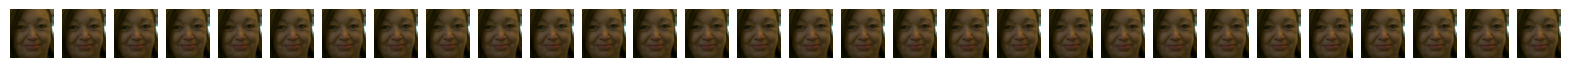

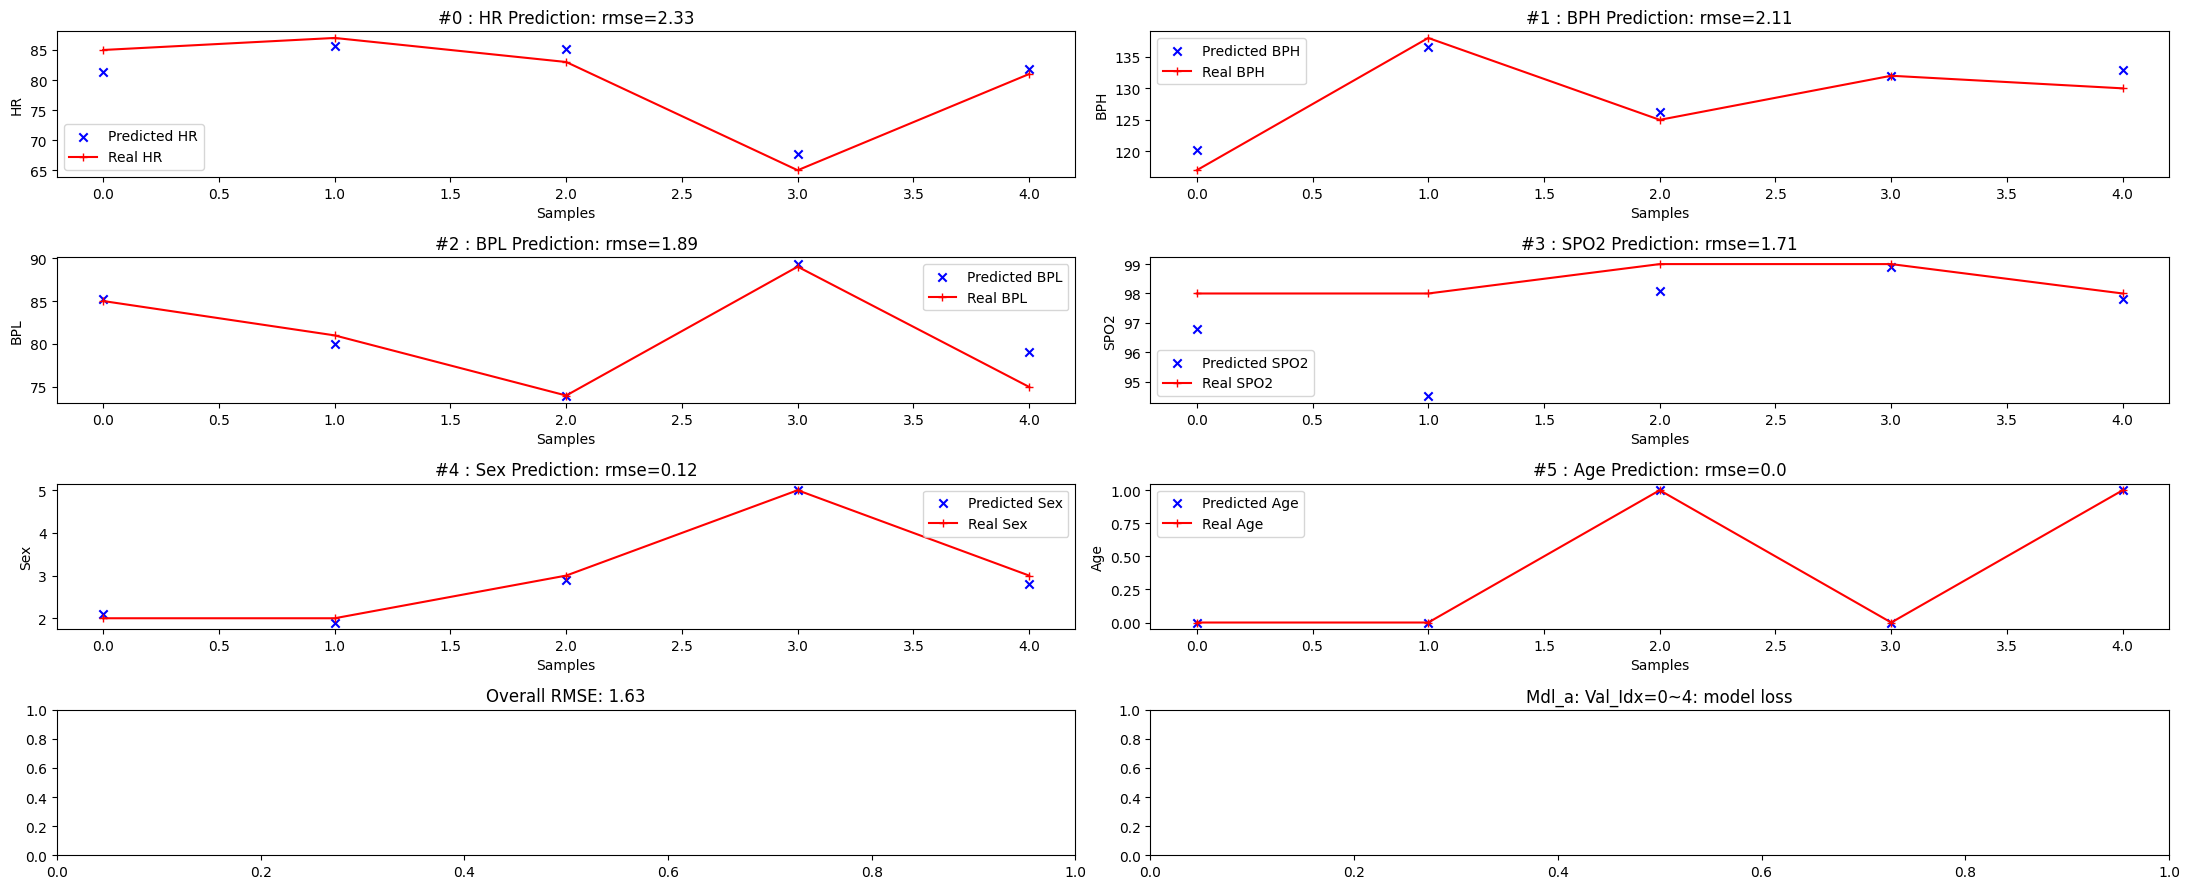

time: 14 s (started: 2025-01-11 21:15:04 -06:00)


In [15]:
flag_sav_rslt = False
flag_conv_y_test = False

# flag_cam=True
# path_fn = '../../../VVD_Data/Cam_FaceX_VitalY/'                   # <<<<<<<<<<<<<<<<<<<<
# Vis_Dynamic_Pred(path_fn+'Cam_12_FaceX_VitalY.npz', strTitle='Cam_12', flag_sav_rslt=flag_sav_rslt, flag_cam=flag_cam)    # Cam_12: first 10s include non-faces

flag_cam=False
# 'Norm_30Frm_ValIdx0-4.npz': 5 samples from the test subset: X normalized to [-1,1], Y ground truth (not scaled)
Vis_Dynamic_Pred('Norm_30Frm_ValIdx0-4.npz', strTitle=mdl_name + ': Val_Idx=0~4', flag_sav_rslt=flag_sav_rslt,  
                 flag_conv_y_test=flag_conv_y_test, flag_cam=flag_cam)
# Vis_Dynamic_Pred('Norm_30Frm_ValIdx250.npz', strTitle=mdl_name + ': Val_Idx=0~4', flag_sav_rslt=flag_sav_rslt,  
#                  flag_conv_y_test=flag_conv_y_test, flag_cam=flag_cam)

# name_vital = ['HR', 'BPH', 'BPL', 'SPO2', 'Sex', 'Age'] #<<<<<<<<<<<<<<<<<<<<<<<<<< Original Order in [Y]
